In [ ]:
import gdown
import os
import zipfile
import shutil
from tqdm.notebook import tqdm as tq

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Load

In [ ]:
# Download file dari Google Drive
file_id = "1nssl01tRJJ8Uu2Y_cIkCwADAcndOQ3m3"
url = f"https://drive.google.com/uc?id={file_id}"

# Simpan data zip
gdown.download(url, "data_zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1nssl01tRJJ8Uu2Y_cIkCwADAcndOQ3m3
From (redirected): https://drive.google.com/uc?id=1nssl01tRJJ8Uu2Y_cIkCwADAcndOQ3m3&confirm=t&uuid=abfc4318-6621-4edb-ac08-3bfaafe5dce2
To: /content/data_zip
100%|██████████| 187M/187M [00:02<00:00, 69.7MB/s]


'data_zip'

In [ ]:
# Ekstrak file zip
with zipfile.ZipFile("data_zip", "r") as zip_ref:
    zip_ref.extractall("extracted_data")

print("Ekstraksi berhasil.")

Ekstraksi berhasil.


Plot Distribution Data

In [ ]:
# Path sumber data
source_path = "/content/extracted_data/content/tea/dataset_augmentation"

# Daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(source_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

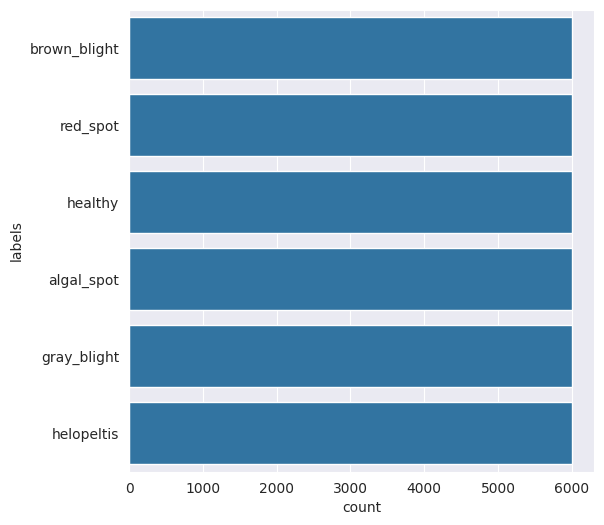

In [ ]:
# Plot distribusi gambar di setiap kelas
Label = df["labels"]

plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Split Dataset

In [ ]:
# Membuat variabel pemisahan, variabel X = data path dan variabel y = data labels
X = df["path"]
y = df["labels"]

# Split dataset menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300, stratify = y)

In [ ]:
# Membuat data frame masing-masing untuk data train dan data test
df_train = pd.DataFrame({"path":X_train, "labels":y_train, "set":"train"})
df_test = pd.DataFrame({"path":X_test, "labels":y_test, "set":"test"})

In [ ]:
# Menggabungkan DataFrame df_train dan df_test
df_all = pd.concat([df_train, df_test], ignore_index=True)

print("===================================================== \n")
print(df_all.groupby(["set", "labels"]).size(), '\n')
print("===================================================== \n")


set    labels      
test   algal_spot      1200
       brown_blight    1200
       gray_blight     1200
       healthy         1200
       helopeltis      1200
       red_spot        1200
train  algal_spot      4800
       brown_blight    4800
       gray_blight     4800
       healthy         4800
       helopeltis      4800
       red_spot        4800
dtype: int64 




In [ ]:
# Membuat path final dataset
dataset_final_path = "/content/extracted_data/content/tea/dataset_final"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row["path"]
    if os.path.exists(file_path) == False:
            file_path = os.path.join(source_path,row["labels"],row["image"].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_final_path,row["set"],row["labels"])) == False:
        os.makedirs(os.path.join(dataset_final_path,row["set"],row["labels"]))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_final_path,row["set"],row["labels"],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Membuat variabel untuk path direktori data train dan data test
TRAIN_DIR = "/content/extracted_data/content/tea/dataset_final/train"
TEST_DIR = "/content/extracted_data/content/tea/dataset_final/test"

In [ ]:
# Membuat objek ImageDataGenerator untuk menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255., validation_split= 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode="categorical",
                                              subset="training",
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TEST_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   class_mode="categorical",
                                                   subset="validation",
                                                   shuffle=False)

"""test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  class_mode="categorical",
                                                  shuffle=False)"""

Found 23040 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.


'test_generator = test_datagen.flow_from_directory(TEST_DIR,\n                                                  batch_size=1,\n                                                  target_size=(224,224),\n                                                  class_mode="categorical",\n                                                  shuffle=False)'

## Modeling

In [ ]:

class CustomCheckpoint(Callback):
    def __init__(self, save_path="saved_model/1", max_gap=0.02, loss_tolerance=0.01):
        super(CustomCheckpoint, self).__init__()
        self.save_path = save_path
        self.max_gap = max_gap
        self.loss_tolerance = loss_tolerance
        self.best_val_acc = 0
        self.best_val_loss = float("inf")  # Inisialisasi dengan nilai sangat besar

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy", 0)
        train_acc = logs.get("accuracy", 0)
        val_loss = logs.get("val_loss", float("inf"))

        # Simpan model jika val_acc meningkat dengan gap kecil dan val_loss membaik
        if (val_acc > self.best_val_acc and abs(train_acc - val_acc) <= self.max_gap
            and val_loss < self.best_val_loss):
            self.best_val_acc = val_acc
            self.best_val_loss = val_loss

            # Simpan model dalam format SavedModel menggunakan tf.saved_model.save
            tf.saved_model.save(self.model, self.save_path)
            print(f"Model disimpan di {self.save_path} dengan val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}, dan gap: {abs(train_acc - val_acc):.4f}")


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=4,
                               min_delta=0.001,
                               restore_best_weights=True,
                               mode='max'
                               )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              mode='auto',
                              )
checkpoint = CustomCheckpoint(save_path="saved_model/1")

In [ ]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in pre_trained_model.layers:
    layer.trainable = False

####################### Init sequential model ##################################
model = Sequential()
model.add(pre_trained_model)

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# 2st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
# model.add(Flatten(name="flatten"))
model.add(GlobalAveragePooling2D()),
# 1nd Dense Layer
model.add(Dropout(0.3))
# 1nd Dropout Layer
model.add(Dense(128, activation="relu"))
# Final Dense layer => For output prediction
model.add(Dense(train_generator.num_classes, activation='softmax'))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile model
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,654,246 (10.13 MB)

 Trainable params: 396,262 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [ ]:
%%time
num_epochs = 50

history = model.fit(train_generator,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    batch_size = 64,
                    callbacks =[early_stopping,reduce_lr],
                    verbose=2)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


720/720 - 56s - 78ms/step - accuracy: 0.7477 - loss: 0.6714 - val_accuracy: 0.8389 - val_loss: 0.4463 - learning_rate: 1.0000e-03
Epoch 2/50
720/720 - 37s - 52ms/step - accuracy: 0.8837 - loss: 0.3361 - val_accuracy: 0.8660 - val_loss: 0.3815 - learning_rate: 1.0000e-03
Epoch 3/50
720/720 - 35s - 48ms/step - accuracy: 0.9133 - loss: 0.2548 - val_accuracy: 0.9049 - val_loss: 0.2944 - learning_rate: 1.0000e-03
Epoch 4/50
720/720 - 34s - 48ms/step - accuracy: 0.9310 - loss: 0.2062 - val_accuracy: 0.9028 - val_loss: 0.2892 - learning_rate: 1.0000e-03
Epoch 5/50
720/720 - 41s - 57ms/step - accuracy: 0.9441 - loss: 0.1664 - val_accuracy: 0.8826 - val_loss: 0.3300 - learning_rate: 1.0000e-03
Epoch 6/50
720/720 - 36s - 50ms/step - accuracy: 0.9502 - loss: 0.1487 - val_accuracy: 0.9125 - val_loss: 0.2683 - learning_rate: 1.0000e-03
Epoch 7/50
720/720 - 35s - 48ms/step - accuracy: 0.9597 - loss: 0.1233 - val_accuracy: 0.9028 - val_loss: 0.3327 - learning_rate: 1.0000e-03
Epoch 8/50
720/720 - 34s

In [ ]:
# Evaluasi model menggunakan data pengujian
evaluation = model.evaluate(
    validation_generator,
    steps=validation_generator.samples,
    callbacks =[early_stopping,reduce_lr]
)

# Menampilkan hasil evaluasi
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9366 - loss: 0.3006   


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Test Loss: 0.3029
Test Accuracy: 0.9361


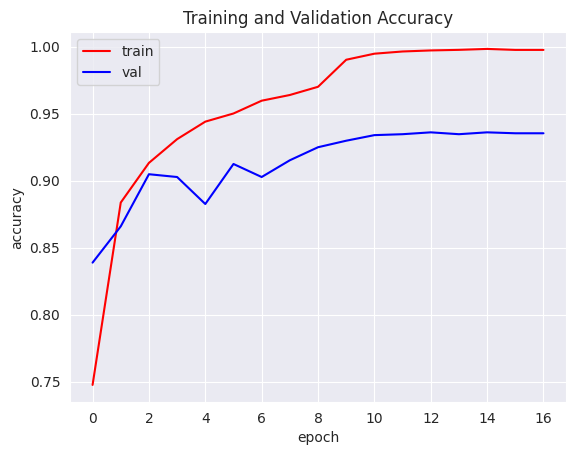

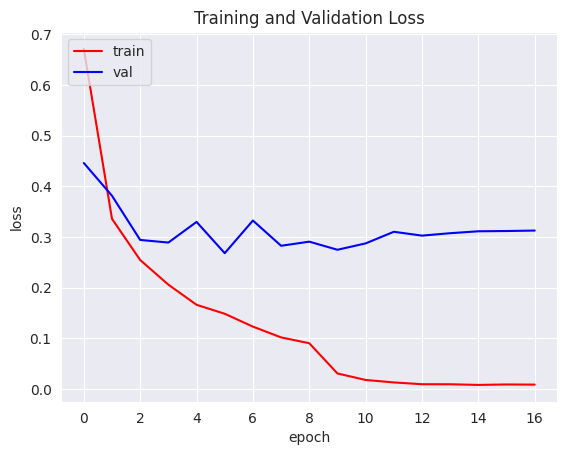

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


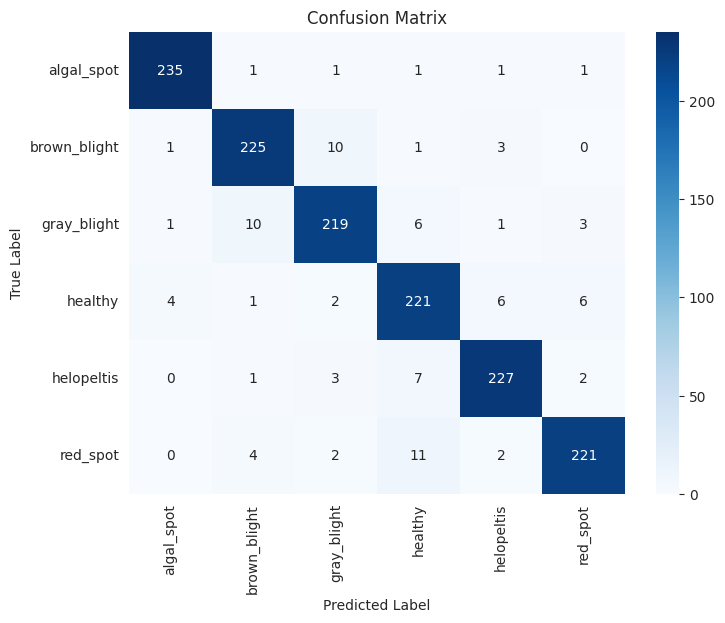


Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9751    0.9792    0.9771       240
brown_blight     0.9298    0.9375    0.9336       240
 gray_blight     0.9241    0.9125    0.9182       240
     healthy     0.8947    0.9208    0.9076       240
  helopeltis     0.9458    0.9458    0.9458       240
    red_spot     0.9485    0.9208    0.9345       240

    accuracy                         0.9361      1440
   macro avg     0.9363    0.9361    0.9361      1440
weighted avg     0.9363    0.9361    0.9361      1440



In [ ]:
validation_generator.reset()

# Prediksi probabilitas kelas
pred_probs = model.predict(validation_generator, verbose=1)

# Mengambil prediksi label (kelas dengan probabilitas tertinggi)
pred_classes = np.argmax(pred_probs, axis=1)

# Label aktual dari generator
true_classes = validation_generator.classes

# Nama kelas dari generator
class_labels = list(validation_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels, digits=4))